In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

In [22]:
res_dir='results/1023random'
#res_dir='results/1023optuna'
res_dir='results/1023optuna_log'

#res_dir='results/1024random'
res_dir='results/1025random16'
#res_dir='results/1024optuna'
res_dir='results/1026optuna16'
res_dir="results/1027_2comp_models_n_lit"
res_dir="results/1027_2comp_models_n_lit_full"
#res_dir="results/1027_3comp_models_n_irr"

json_files = glob.glob(res_dir+'/*.json')
print(len(json_files))
res_list=[]
for json_file in json_files:
    res_list.extend(json.load(open(json_file)))

1


In [23]:

for res in res_list:
    keys=res["lola_layer_dict"]

    for k,v in keys.items():
        if v:
            res[f"{k}"]=1
        else:
            res[f"{k}"]=0
    keys=res["train_context_dict"]
    for k,v in keys.items():
        if v:
            res[f"C{k}"]=1
        else:
            res[f"C{k}"]=0

In [24]:
df=pd.DataFrame(res_list)
df = df.select_dtypes(include=['number'])
cols = [col for col in df if col != 'score'] + ['score']
del_columns=[
'per_device_train_batch_size',
"total_epochs",
]
for c in del_columns:
    cols.remove(c) 
df = df[cols]
cols.remove('score')
df=df.drop_duplicates(subset=cols)
df=df.sort_values(by='score',ascending=False)

if "bit" not in df.columns:
    df["bit"]=4

df["bit"].fillna(4,inplace=True)

print(df.shape)
df[df["n_irrelevant_texts"]>1000][:5]
df.columns

(10, 31)


Index(['bit', 'n_irrelevant_texts', 'r', 'lr', 'lora_alpha', 'inner_epochs',
       'n_lit', 'model_size', 'epoch', 'embed_tokens', 'lm_head', 'q_proj',
       'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'C1',
       'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'score'],
      dtype='object')

In [25]:
#sns.set_style("whitegrid")
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6, 6]
sns.set_palette("muted")
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Text(0.5, 0, 'Correlation with score')

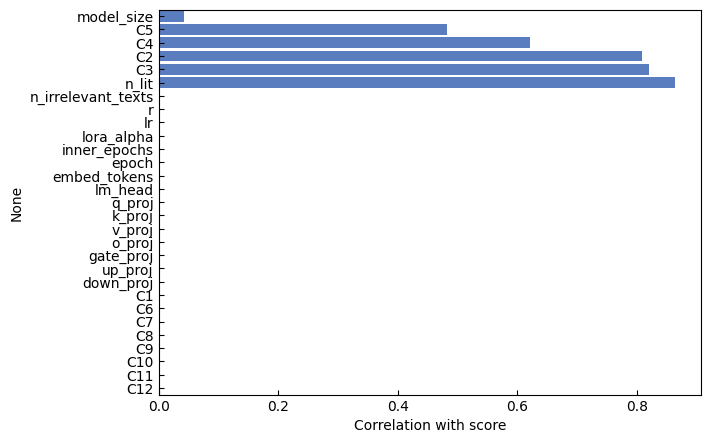

In [26]:

plt.rcParams['font.size'] = 10
plt.figure(figsize=(7,5))
score_df=df.corr()["score"].drop(["score","bit"]).sort_values()
sns.barplot(x=score_df.values,y=score_df.index)
plt.xlabel("Correlation with score")

In [27]:
df

,bit,n_irrelevant_texts,r,lr,lora_alpha,inner_epochs,n_lit,model_size,epoch,embed_tokens,...,C4,C5,C6,C7,C8,C9,C10,C11,C12,score
4,16,0,100,0.0002,300,10,4,7,1,1,...,1,1,0,0,0,0,0,0,0,0.960000
7,16,0,100,0.0002,300,10,2,13,1,1,...,0,0,0,0,0,0,0,0,0,0.893333
8,16,0,100,0.0002,300,10,3,13,1,1,...,1,0,0,0,0,0,0,0,0,0.860000
9,16,0,100,0.0002,300,10,4,13,1,1,...,1,1,0,0,0,0,0,0,0,0.793333
3,16,0,100,0.0002,300,10,3,7,1,1,...,1,0,0,0,0,0,0,0,0,0.673333
1,16,0,100,0.0002,300,10,1,7,1,1,...,0,0,0,0,0,0,0,0,0,0.640000
2,16,0,100,0.0002,300,10,2,7,1,1,...,0,0,0,0,0,0,0,0,0,0.600000
6,16,0,100,0.0002,300,10,1,13,1,1,...,0,0,0,0,0,0,0,0,0,0.373333
5,16,0,100,0.0002,300,10,0,13,1,1,...,0,0,0,0,0,0,0,0,0,0.206667
0,16,0,100,0.0002,300,10,0,7,1,1,...,0,0,0,0,0,0,0,0,0,0.140000


/home/hatakeyama/miniconda3/envs/ft/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hatakeyama/miniconda3/envs/ft/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(63.08333333333333, 0.5, '')

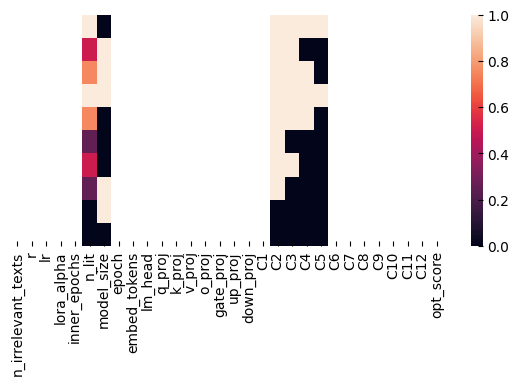

In [28]:
normalized_df =df.copy()

normalized_df["opt_score"]=normalized_df["score"]*np.log10(normalized_df["n_irrelevant_texts"])
log_labels=[
"epoch",
"r",
"lr",
"lora_alpha",
"n_irrelevant_texts",
]

normalized_df=normalized_df.sort_values("opt_score",ascending=False).drop(["bit","score"],axis=1)

for l in log_labels:
    normalized_df[l]=np.log10(normalized_df[l])
normalized_df=(normalized_df - normalized_df.min()) / (normalized_df.max() - normalized_df.min())

plt.rcParams['font.size'] = 10
plt.figure(figsize=(7,3))
ax=sns.heatmap(normalized_df[:])
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none')
#plt.xticks(fontsize=6)
plt.yticks()
plt.ylabel("")

/tmp/ipykernel_1895139/937875115.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


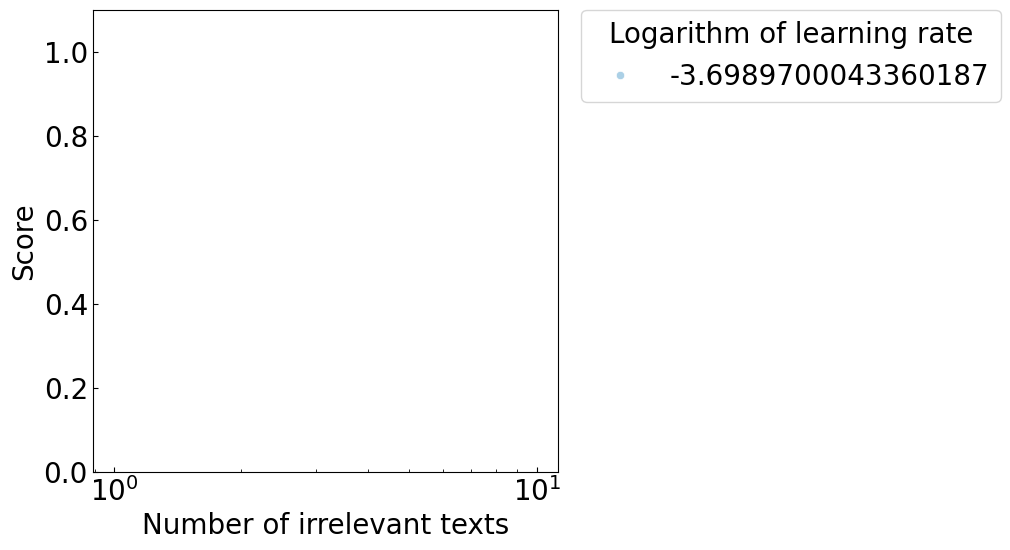

In [29]:

plt.rcParams['font.size'] = 20

plt_df=df.copy()
plt_df["log_lr"]=np.log10(plt_df["lr"])
#sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="epoch")
sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="log_lr",palette="Blues_d")
plt.xscale("log")

plt.ylim(0,1.1)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title="Logarithm of learning rate")

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression
plt_df=df.copy()
plt_df=plt_df[plt_df["score"]>0.5]
mean_df=plt_df.groupby(by="n_irrelevant_texts").max().reset_index()

x=mean_df["n_irrelevant_texts"]
y=mean_df["lr"]
logx=np.array(np.log10(x)).reshape(-1,1)
logy=np.array(np.log10(y)).reshape(-1,1)

reg=LinearRegression()
reg.fit(logx,logy)
pred_y=reg.predict(logx)
mean_df["regression"]=10**pred_y

plt.scatter(mean_df["n_irrelevant_texts"],mean_df["lr"])
plt.plot(mean_df["n_irrelevant_texts"],mean_df["regression"],c="gray")


plt.xscale("log")
plt.yscale("log")
plt.xlim(10,5000)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Learning rate")
reg.coef_,reg.intercept_

/home/hatakeyama/miniconda3/envs/ft/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
10**(-0.38*np.log10(5000)-2.37)

0.00016764530618725815

/tmp/ipykernel_1895139/423046422.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",palette="Blues_d")
/tmp/ipykernel_1895139/423046422.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


Text(0, 0.5, 'Score')

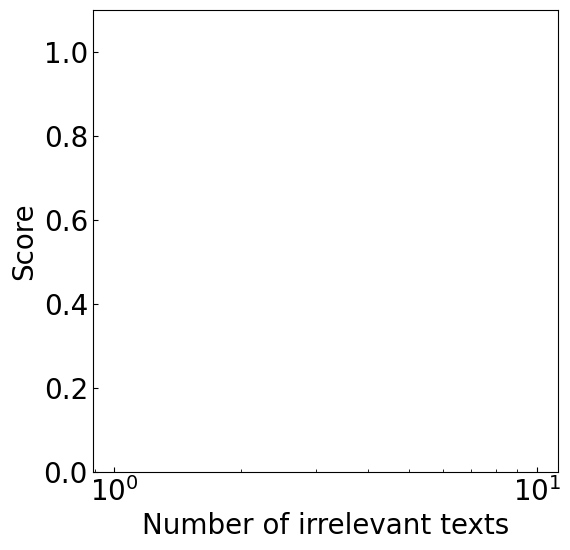

In [32]:


plt.rcParams['font.size'] = 20

plt_df=df.copy()
plt_df["log_lr"]=np.log10(plt_df["lr"])
#sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="epoch")
sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",palette="Blues_d")
plt.xscale("log")

plt.ylim(0,1.1)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title="Logarithm of learning rate")

/home/hatakeyama/miniconda3/envs/ft/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1895139/827119728.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


Text(0, 0.5, 'Score')

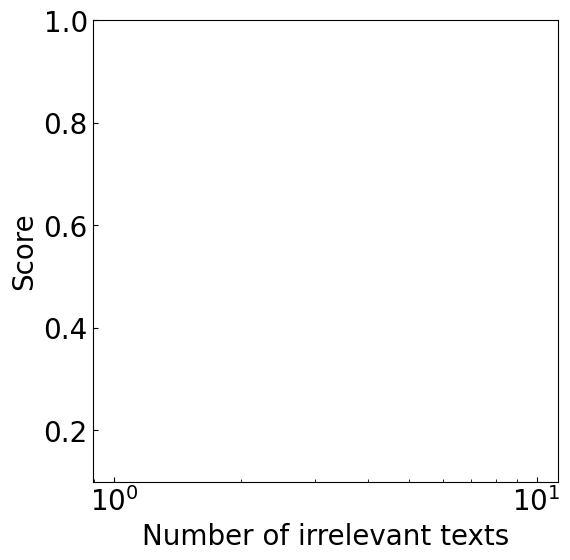

In [33]:
plt_df["opt_score"]=plt_df["score"]*np.log10(plt_df["n_irrelevant_texts"])
ax=sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="opt_score",palette="Blues_d")
plt.xscale("log")

ax.legend_.remove() 
#legendは非表示にしたい
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")


/tmp/ipykernel_1895139/826586496.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


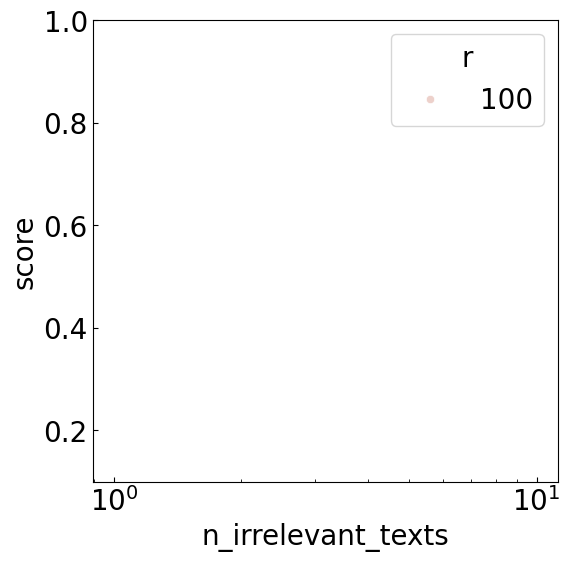

In [34]:

sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="r")

plt.xscale("log")

(0.0, 1.1)

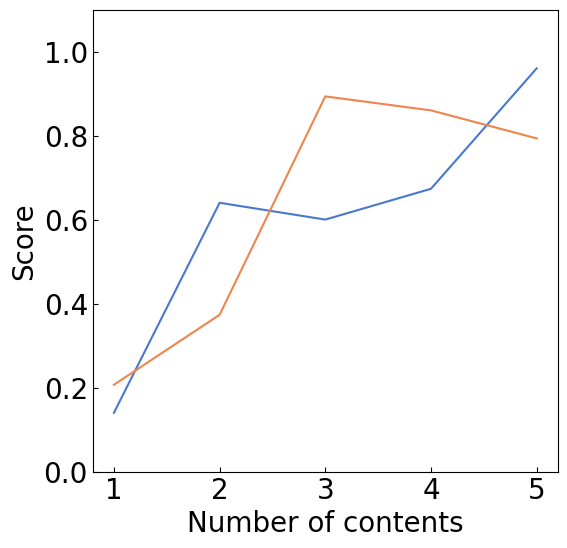

In [35]:
plt_df=df.copy()
plt_df=plt_df.sort_values(by=["model_size","bit"])
plt_df["model_cond"]=plt_df["model_size"].astype(str)+"b-"+plt_df["bit"].astype(str)+"bit"
plt_df["n_lit"]+=1
ax=sns.lineplot(data=plt_df,x="n_lit",y="score",hue="model_cond")

plt.legend(title="",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)
ax.legend_.remove() 
plt.xlabel("Number of contents")
plt.ylabel("Score")
plt.ylim(0,1.1)

In [36]:
plt_df

,bit,n_irrelevant_texts,r,lr,lora_alpha,inner_epochs,n_lit,model_size,epoch,embed_tokens,...,C5,C6,C7,C8,C9,C10,C11,C12,score,model_cond
4,16,0,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.960000,7b-16bit
3,16,0,100,0.0002,300,10,4,7,1,1,...,0,0,0,0,0,0,0,0,0.673333,7b-16bit
1,16,0,100,0.0002,300,10,2,7,1,1,...,0,0,0,0,0,0,0,0,0.640000,7b-16bit
2,16,0,100,0.0002,300,10,3,7,1,1,...,0,0,0,0,0,0,0,0,0.600000,7b-16bit
0,16,0,100,0.0002,300,10,1,7,1,1,...,0,0,0,0,0,0,0,0,0.140000,7b-16bit
7,16,0,100,0.0002,300,10,3,13,1,1,...,0,0,0,0,0,0,0,0,0.893333,13b-16bit
8,16,0,100,0.0002,300,10,4,13,1,1,...,0,0,0,0,0,0,0,0,0.860000,13b-16bit
9,16,0,100,0.0002,300,10,5,13,1,1,...,1,0,0,0,0,0,0,0,0.793333,13b-16bit
6,16,0,100,0.0002,300,10,2,13,1,1,...,0,0,0,0,0,0,0,0,0.373333,13b-16bit
5,16,0,100,0.0002,300,10,1,13,1,1,...,0,0,0,0,0,0,0,0,0.206667,13b-16bit


/tmp/ipykernel_1895139/2080776050.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


(0.0, 1.1)

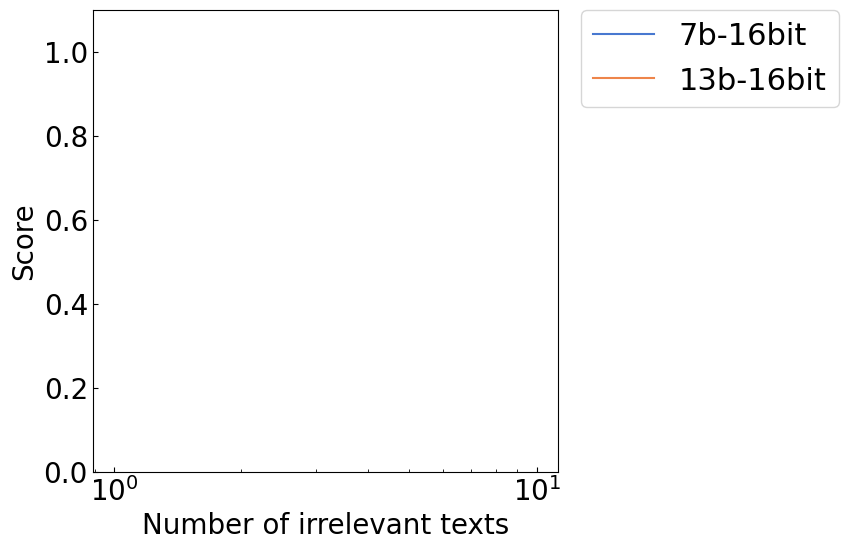

In [37]:

plt_df=df.copy()
plt_df["model_cond"]=plt_df["model_size"].astype(str)+"b-"+plt_df["bit"].astype(str)+"bit"
ax=sns.lineplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="model_cond")

plt.xscale("log")

plt.legend(title="",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")
plt.ylim(0,1.1)

In [38]:
plt_df

,bit,n_irrelevant_texts,r,lr,lora_alpha,inner_epochs,n_lit,model_size,epoch,embed_tokens,...,C5,C6,C7,C8,C9,C10,C11,C12,score,model_cond
4,16,0,100,0.0002,300,10,4,7,1,1,...,1,0,0,0,0,0,0,0,0.960000,7b-16bit
7,16,0,100,0.0002,300,10,2,13,1,1,...,0,0,0,0,0,0,0,0,0.893333,13b-16bit
8,16,0,100,0.0002,300,10,3,13,1,1,...,0,0,0,0,0,0,0,0,0.860000,13b-16bit
9,16,0,100,0.0002,300,10,4,13,1,1,...,1,0,0,0,0,0,0,0,0.793333,13b-16bit
3,16,0,100,0.0002,300,10,3,7,1,1,...,0,0,0,0,0,0,0,0,0.673333,7b-16bit
1,16,0,100,0.0002,300,10,1,7,1,1,...,0,0,0,0,0,0,0,0,0.640000,7b-16bit
2,16,0,100,0.0002,300,10,2,7,1,1,...,0,0,0,0,0,0,0,0,0.600000,7b-16bit
6,16,0,100,0.0002,300,10,1,13,1,1,...,0,0,0,0,0,0,0,0,0.373333,13b-16bit
5,16,0,100,0.0002,300,10,0,13,1,1,...,0,0,0,0,0,0,0,0,0.206667,13b-16bit
0,16,0,100,0.0002,300,10,0,7,1,1,...,0,0,0,0,0,0,0,0,0.140000,7b-16bit
